In [94]:
import pandas as pd

# 读取污染物浓度数据（附件1）和气象数据（附件2）
pollution_data = pd.read_excel("附件1：污染物浓度数据.xlsx", engine="openpyxl")
weather_data = pd.read_excel("附件2：气象数据.xlsx", engine="openpyxl")

# # 将质量等级转换为数值型数据（独热编码）
# all_categories = ['优', '良', '轻度污染', '中度污染', '重度污染', '严重污染']
# pollution_data['质量等级'] = pd.Categorical(pollution_data['质量等级'], categories=all_categories)
# pollution_data = pd.concat([pollution_data, pd.get_dummies(pollution_data["质量等级"])], axis=1)
# pollution_data.drop("质量等级", axis=1, inplace=True)

# 合并数据集
merged_data = pollution_data.merge(weather_data, left_on=["年", "月", "日"], right_on=["V04001", "V04002", "V04003"])

# 移除不需要的列
merged_data.drop(["年", "日", "V04001", "V04002", "V04003", "V01301","质量等级","AQI"], axis=1, inplace=True)

# 删除包含缺失值的行
merged_data.dropna(axis=0, inplace=True)



查看各个数据的大体趋势

D:\Python\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


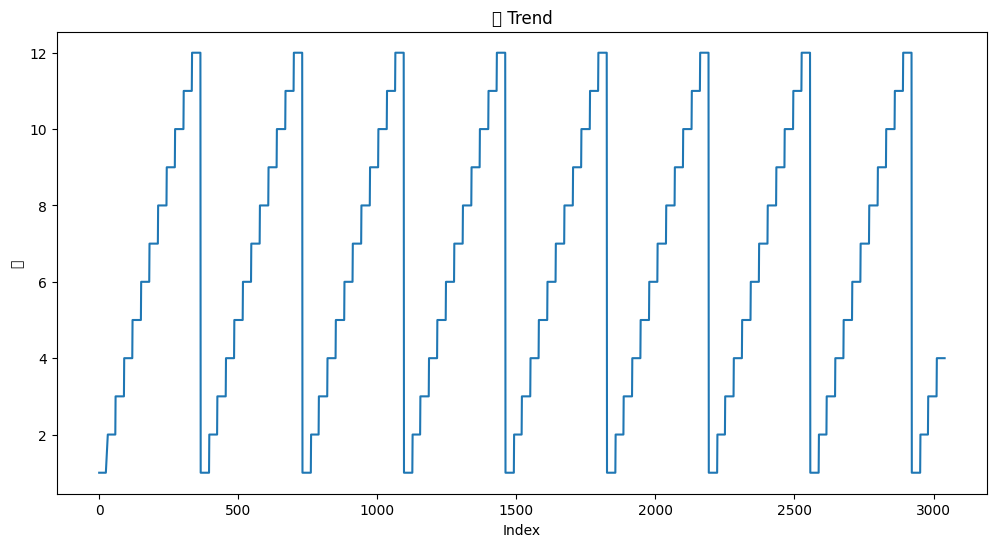

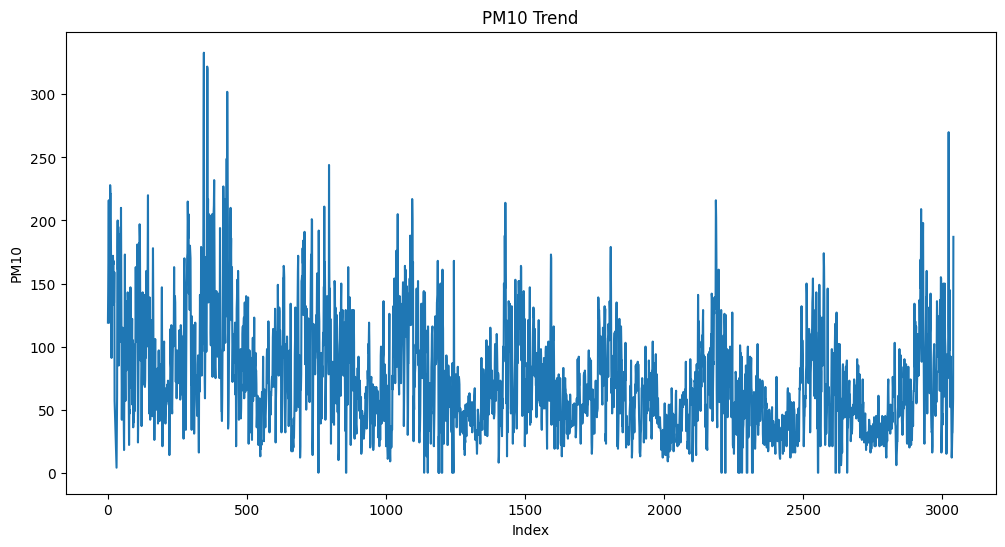

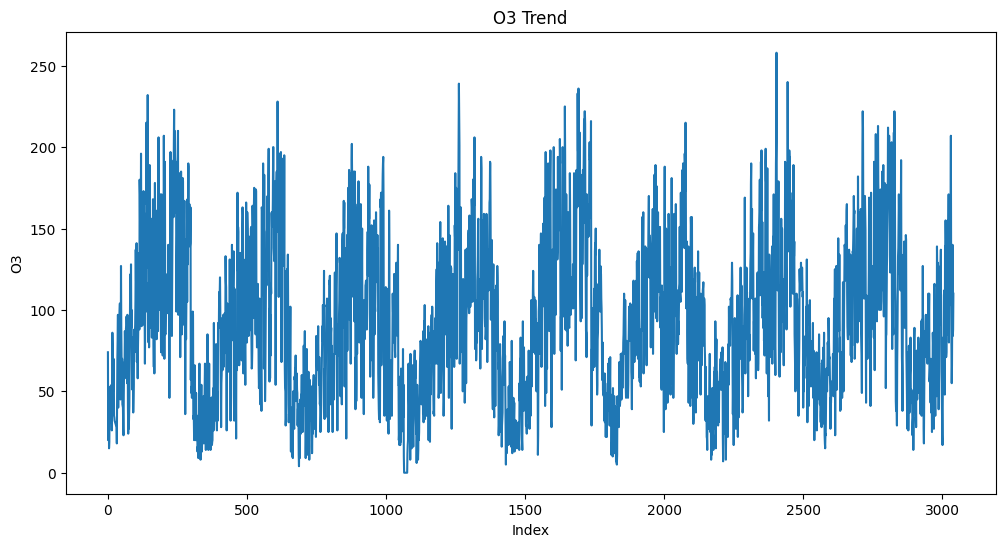

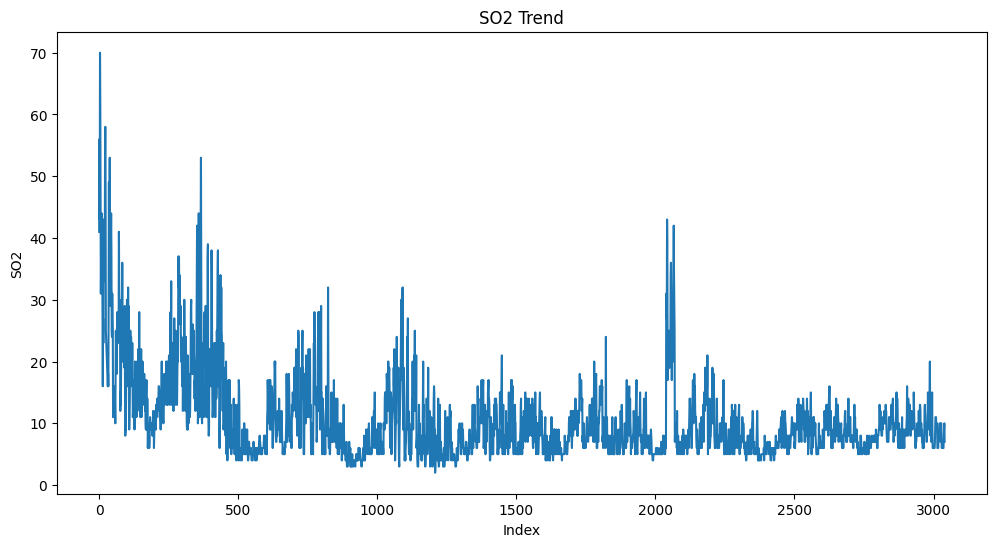

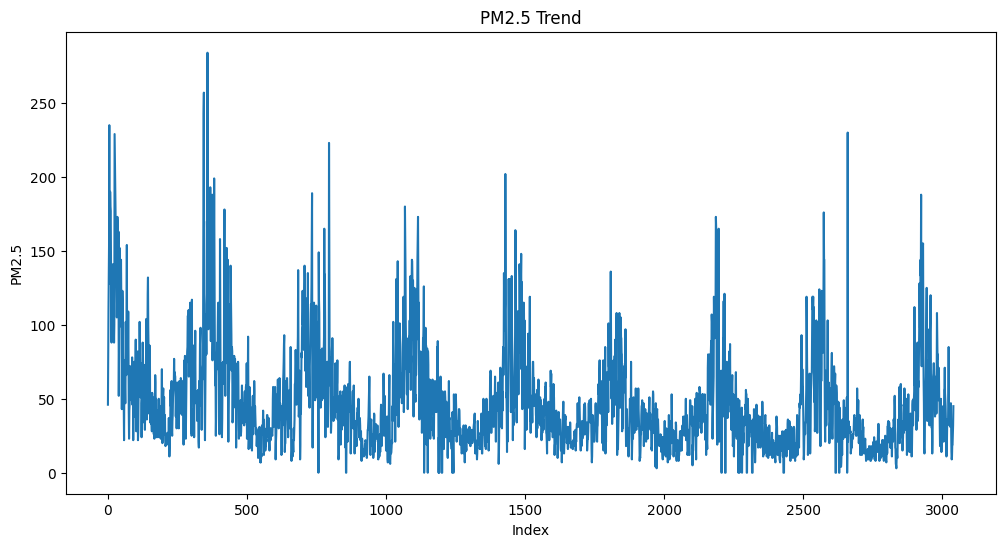

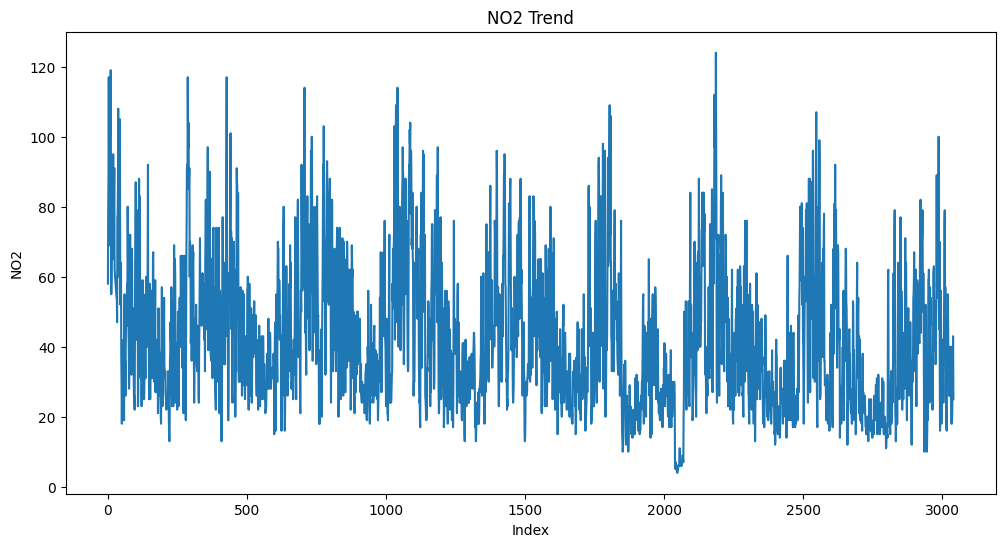

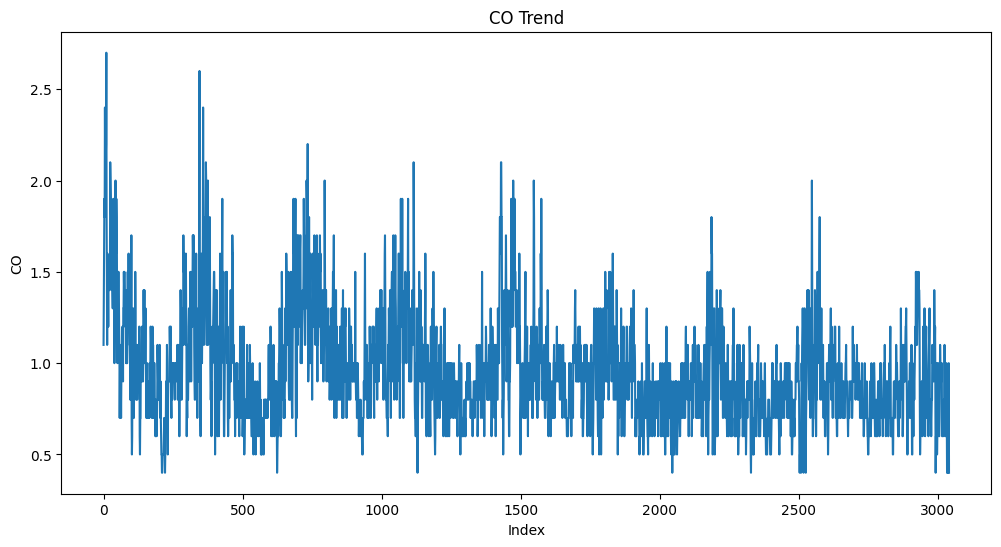

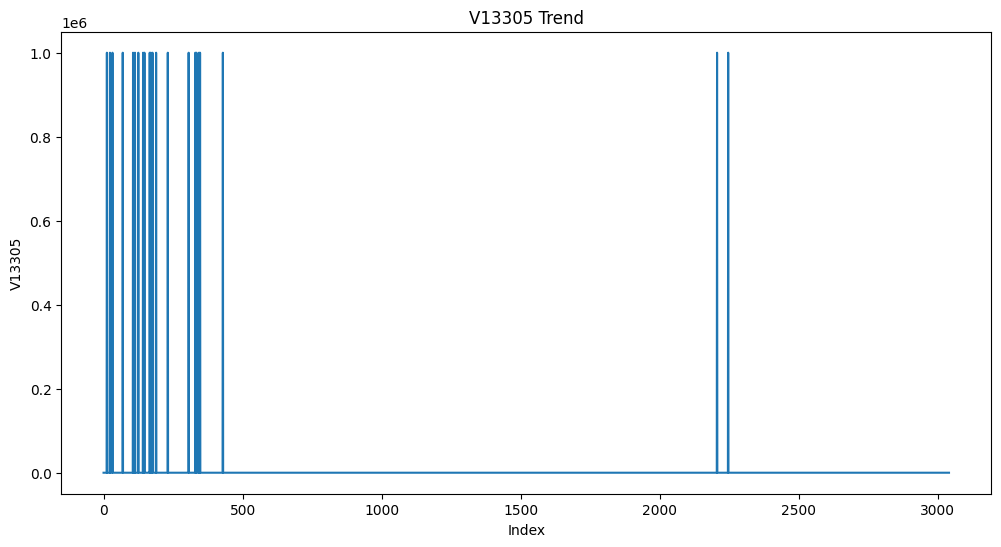

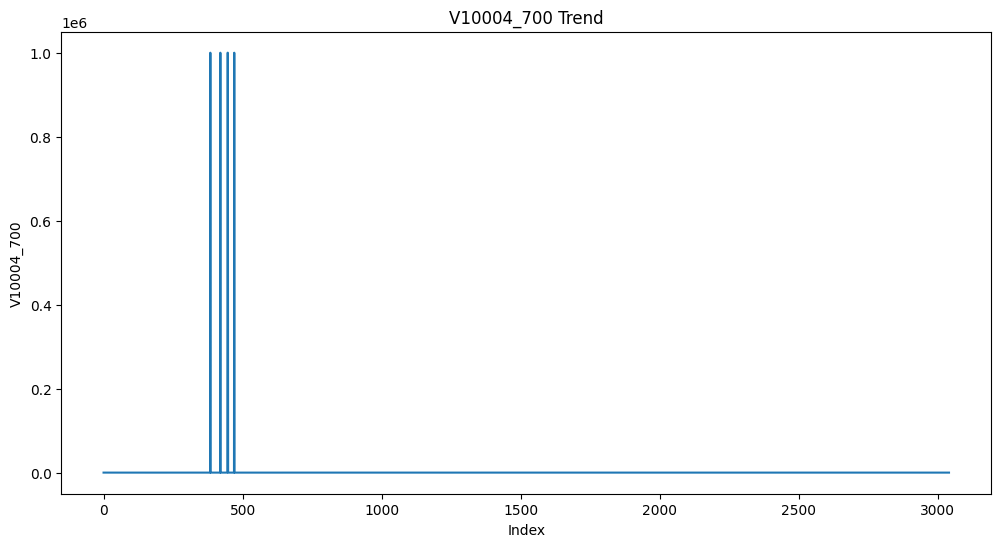

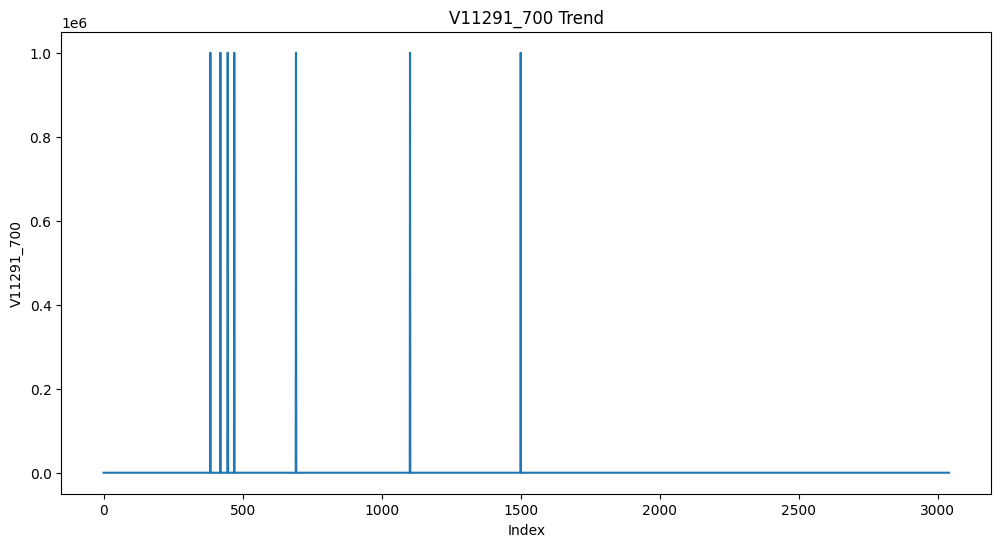

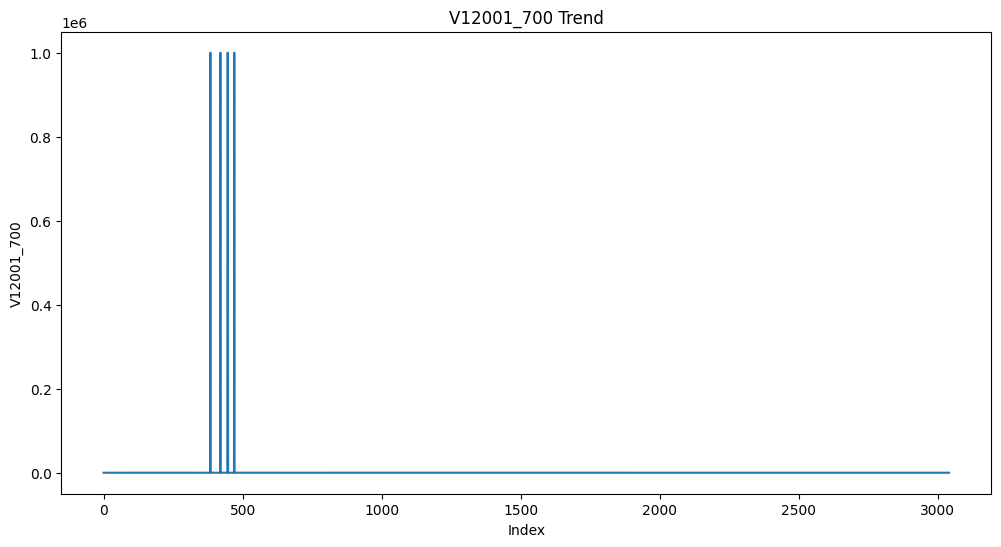

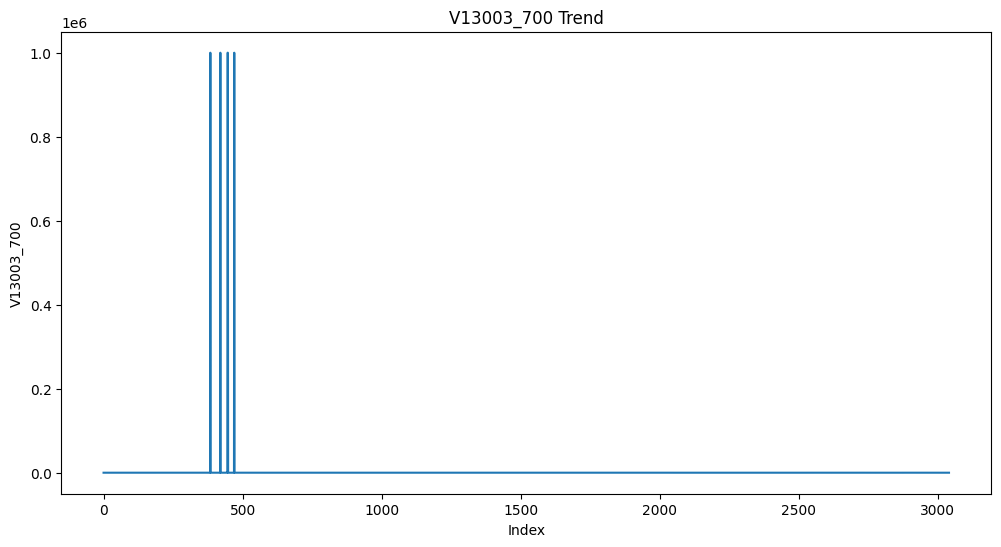

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt
# 获取所有列名
column_names = list(merged_data.columns)

# 为每个列绘制趋势图
for column_name in column_names:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=merged_data[column_name])
    plt.xlabel('Index')
    plt.ylabel(column_name)
    plt.title(f'{column_name} Trend')
    plt.show()

数据预处理：运用回归插补方法

In [100]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def remove_outliers_iqr(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df > lower_bound) & (df < upper_bound)]

# 移除异常值
merged_data_no_outliers = remove_outliers_iqr(merged_data)

# 将缺失值替换为NaN
merged_data_no_outliers.replace(to_replace={col: {value: np.nan for value in merged_data_no_outliers[col].unique() if pd.isna(value)} for col in merged_data_no_outliers.columns}, inplace=True)

# 使用回归插补填充缺失值
imputer = IterativeImputer(random_state=42, max_iter=50)
imputed_data = imputer.fit_transform(merged_data_no_outliers)

# 将结果转换回DataFrame
imputed_data_df = pd.DataFrame(imputed_data, columns=merged_data_no_outliers.columns)

这是用k-NN去噪算法的代码，但是效果并不理想

D:\Python\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


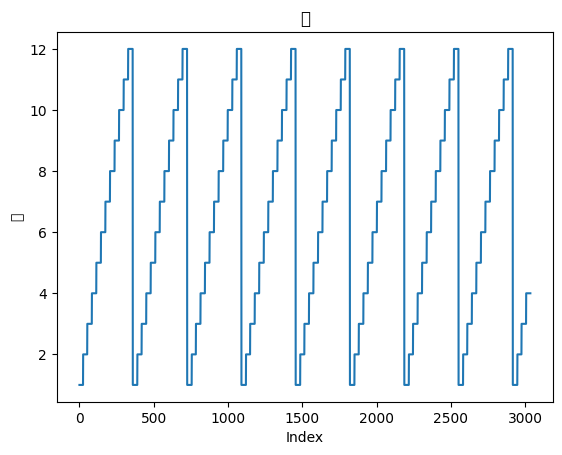

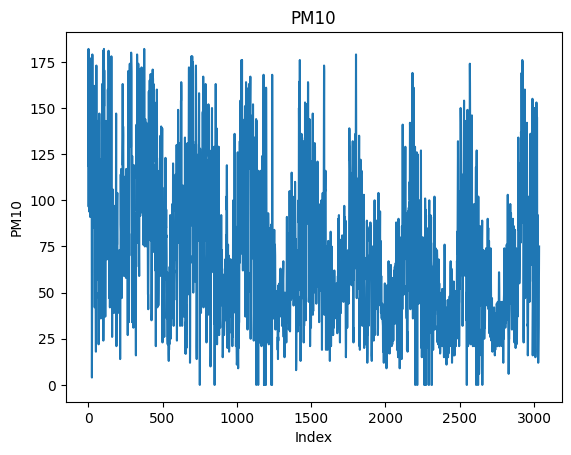

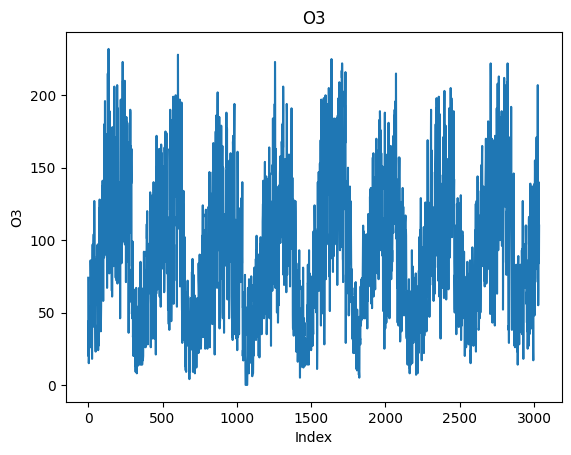

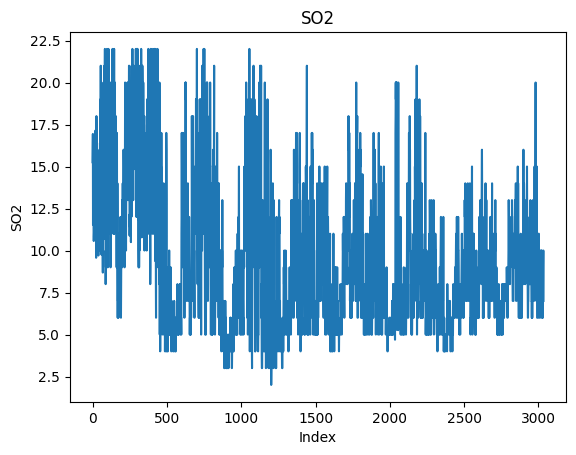

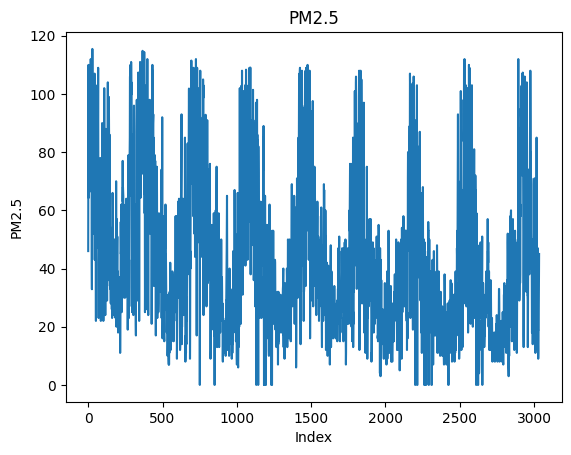

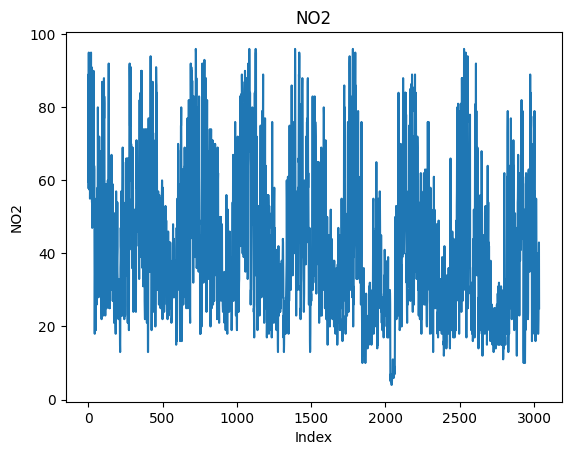

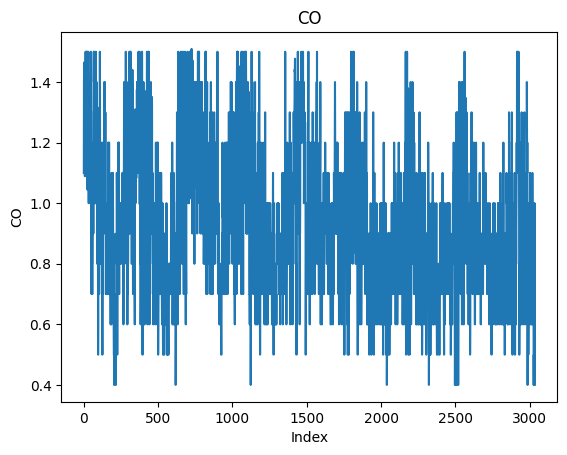

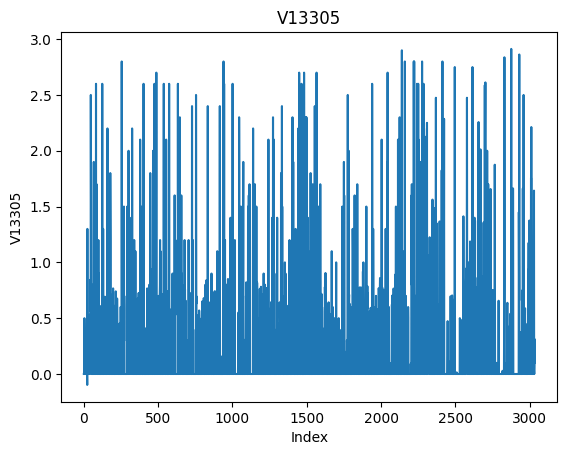

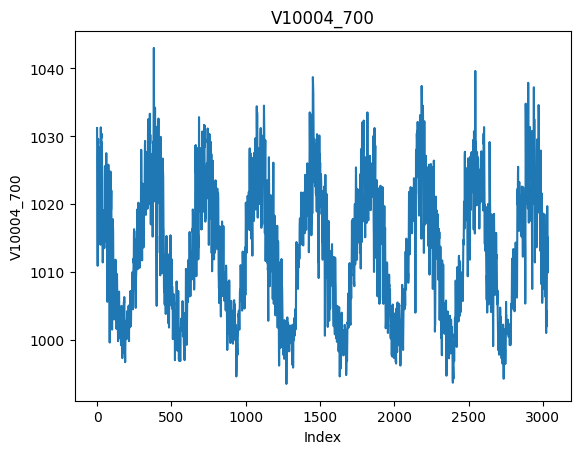

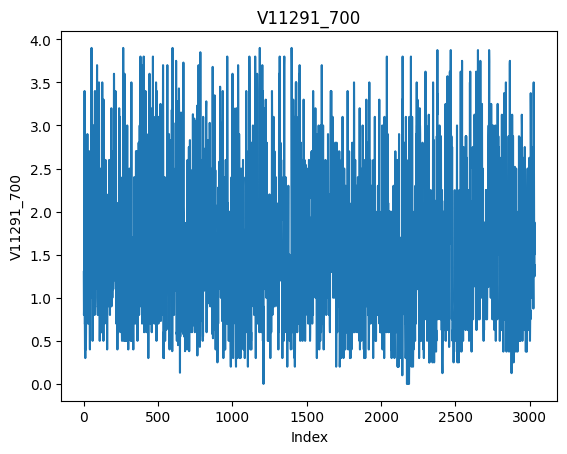

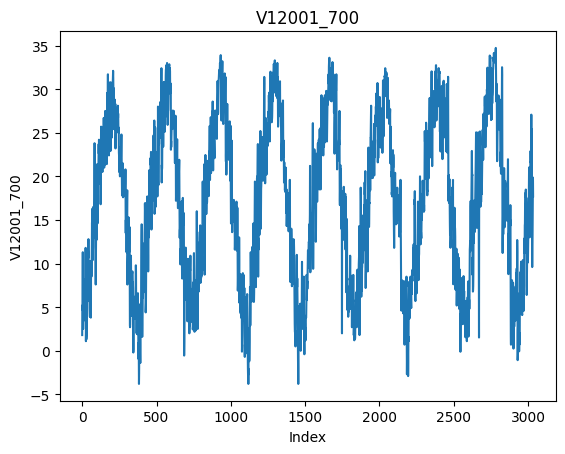

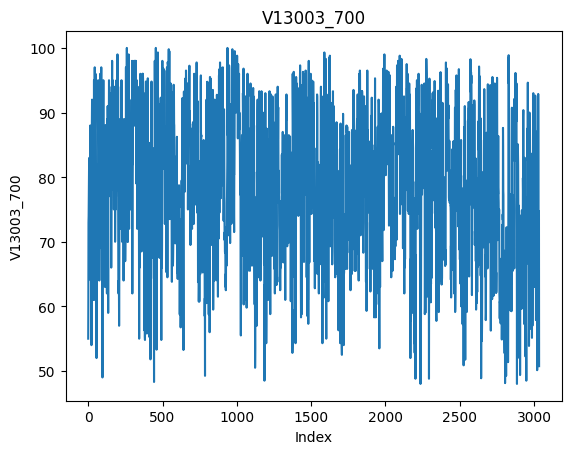

In [98]:
# 绘制各列的趋势图
for column in imputed_data_df.columns:
    plt.figure()
    imputed_data_df[column].plot(title=column)
    plt.xlabel("Index")
    plt.ylabel(column)
    plt.show()

In [101]:
imputed_data_df.to_csv("3000data.csv", index=False, encoding="utf-8")

# 用皮尔逊系数简单直观的看每个数据之间的关系

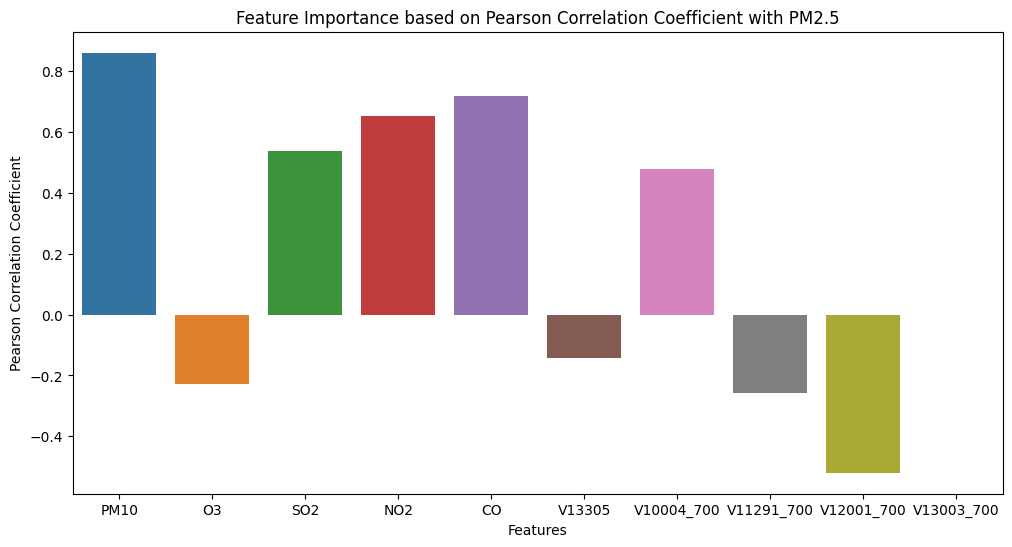

In [91]:
# 假设你已经创建了一个包含所有特征和目标变量（PM2.5）的数据框（data_frame）
correlations = imputed_data_df.corr()

# 获取特征与PM2.5之间的皮尔逊相关系数
pm25_correlations = correlations["PM2.5"].drop("PM2.5", axis=0)  # 移除PM2.5与自身的相关性

# 创建一个条形图
plt.figure(figsize=(12, 6))
sns.barplot(x=pm25_correlations.index, y=pm25_correlations.values)

# 设置图表标题和坐标轴标签
plt.title("Feature Importance based on Pearson Correlation Coefficient with PM2.5")
plt.xlabel("Features")
plt.ylabel("Pearson Correlation Coefficient")

# 显示图表
plt.show()

In [93]:
# 打印每个特征与PM2.5的相关系数
print(pm25_correlations)

PM10          0.860233
O3           -0.228134
SO2           0.536584
NO2           0.651870
CO            0.719464
V13305       -0.144150
V10004_700    0.478680
V11291_700   -0.259305
V12001_700   -0.519695
V13003_700   -0.001804
Name: PM2.5, dtype: float64


In [87]:
# 划分训练集和测试集
train_data = imputed_data_df.sample(frac=0.8, random_state=1)
test_data = imputed_data_df.drop(train_data.index)

# 保存训练集和测试集到CSV文件
train_data.to_csv("train_data2.csv", index=False, encoding="utf-8")
test_data.to_csv("test_data2.csv", index=False, encoding="utf-8")


# 模型训练

In [88]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# 特征矩阵X，我们从merged_data中删除PM2.5列
X_train = train_data.drop("PM2.5", axis=1)
# 目标向量y，即PM2.5值
y_train = train_data["PM2.5"]

X_test = test_data.drop("PM2.5", axis=1)
y_test = test_data["PM2.5"]

#创建随机森林模型
rf = RandomForestRegressor(n_estimators=100, random_state=43)
#训练模型
rf.fit(X_train, y_train)
#使用模型预测测试集
y_pred = rf.predict(X_test)
#计算模型的均方根误差（RMSE）
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

#输出特征重要性
#feature_importances = rf.feature_importances_
#for feature, importance in zip(X_train.columns, feature_importances):
#    print(f"{feature}: {importance}")

feature_names = list(X_train.columns)

# 获取特征名称和对应的重要性值
feature_importances = list(zip(feature_names, rf.feature_importances_))

# 对特征重要性进行降序排序
sorted_feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

# 输出排序后的特征名称和重要性值
for feature, importance in sorted_feature_importances:
    print(f"Feature: {feature}, Importance: {importance}")


RMSE: 8.005916574491268
Feature: PM10, Importance: 0.7176692863309784
Feature: CO, Importance: 0.1040692689139474
Feature: V12001_700, Importance: 0.09673822004041899
Feature: V13003_700, Importance: 0.018524213707949752
Feature: NO2, Importance: 0.015518171470103571
Feature: V10004_700, Importance: 0.012205533452131656
Feature: SO2, Importance: 0.011964290143324065
Feature: O3, Importance: 0.010417124790697323
Feature: V11291_700, Importance: 0.009344063427577275
Feature: V13305, Importance: 0.0035498277228716017


# 第二小问

用随机森林的原函数用不了，改用别的方法

print(f'Number of features in X_train_lagged: {X_train_lagged.shape[1]}')
print(f'Number of features in X_train: {X_train.shape[1]}')

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

进行归一化处理

In [ ]:
#选择需要归一化的列，并将其转换为NumPy数组：
columns_to_normalize = ['PM2.5', 'PM10', 'CO', 'V12001_700', 'V13003_700', 'NO2', 'SO2', '月']  # 使用你需要归一化的列名替换这里的列名
data_values = imputed_data_df[columns_to_normalize].values

#创建MinMaxScaler对象，并用训练集数据拟合它：
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data_values)  # 使用你的数据拟合scaler

#使用拟合好的scaler对数据进行转换：
data_normalized = scaler.transform(data_values)
#将归一化后的数据替换到原始DataFrame中：
imputed_data_df[columns_to_normalize] = data_normalized

时间序列数据转换为滑动窗口形式的监督学习问题

In [ ]:
#定义一个函数，用于将数据转换为LSTM所需的格式：
def create_dataset(dataset, look_back=1):
    data_x, data_y = [], []
    for i in range(len(dataset) - look_back):
        data_x.append(dataset[i:(i + look_back), :])
        data_y.append(dataset[i + look_back, 3])  # 假设 PM2.5 是第一列（索引为0）
    return np.array(data_x), np.array(data_y)

look_back = 3  # 更改此值以设置窗口大小
ques2_data_values = imputed_data_df.values  # 从DataFrame中提取值
ques2_data_x, ques2_data_y = create_dataset(ques2_data_values, look_back)

#将数据划分为训练集和测试集(我们将20%的数据保留为测试集)：
#不应对时间序列数据进行随机抽样，因此将shuffle参数设置为False
ques2_train_x, ques2_test_x, ques2_train_y, ques2_test_y = train_test_split(ques2_data_x, ques2_data_y, test_size=0.2, shuffle=False)

model = Sequential()
model.add(LSTM(50, input_shape=(ques2_train_x.shape[1], ques2_train_x.shape[2])))  # 50 个 LSTM 单元
model.add(Dense(1))  # 输出层，1 个神经元，用于预测 PM2.5
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(ques2_train_x, ques2_train_y, epochs=100, batch_size=32, validation_data=(test_x, test_y), verbose=2, shuffle=False)


In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

对测试集进行预测并计算预测结果的RMSE

In [ ]:
# 预测测试集数据
predicted_test_y = model.predict(test_x)

# 反归一化预测结果
predicted_test_y = scaler_y.inverse_transform(predicted_test_y)

# 反归一化真实值
real_test_y = scaler_y.inverse_transform(test_y)

# 计算预测结果的 RMSE
rmse = np.sqrt(mean_squared_error(real_test_y, predicted_test_y))
print(f"Test RMSE: {rmse}")
